In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import re

# Dataset

In [5]:
data = pd.read_csv('data/created_datasets/humicroedit_unpaired_train.csv')
data.head()

,text,meanGrade,score_std,basic_score,scaled_mean
0,Trump cites fake boob to make the case that su...,1.166667,0.687184,0.0,0.388889
1,Louisiana school district : All students must ...,1.000000,0.632456,0.0,0.333333
2,Green receives standing ovation at ‘ The Colo...,1.600000,1.200000,1.0,0.533333
3,Judge Orders State Department To Provide Withh...,1.000000,0.632456,0.0,0.333333
4,ATT Loses Another 1.36 Million Pay TV Subscrib...,1.400000,0.800000,0.0,0.466667


In [6]:
data.shape

(21990, 5)

In [7]:
sent = data.loc[0].text
sent

'Trump cites fake boob to make the case that support for impeachment is falling'

# Load the model and try

In [8]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
def run_pretrained_for_sentence(sent, len_sent = 25):
    tokens = tokenizer.tokenize(sent)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    padded_tokens = tokens + ['[PAD]' for _ in range(len_sent - len(tokens))]
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    sent_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    #Step 5: Get BERT vocabulary index for each token
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    #Converting everything to torch tensors before feeding them to bert_model
    token_ids = torch.tensor(token_ids).unsqueeze(0) 
    attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
    #Feed them to bert
    hidden_reps, cls_head = bert_model(token_ids, attention_mask = attn_mask)
    
    return hidden_reps, cls_head

In [10]:
%timeit run_pretrained_for_sentence("Test this function")

74.5 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Actually training model

Note: a lot borrowed from https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa

In [11]:
data.head()

,text,meanGrade,score_std,basic_score,scaled_mean
0,Trump cites fake boob to make the case that su...,1.166667,0.687184,0.0,0.388889
1,Louisiana school district : All students must ...,1.000000,0.632456,0.0,0.333333
2,Green receives standing ovation at ‘ The Colo...,1.600000,1.200000,1.0,0.533333
3,Judge Orders State Department To Provide Withh...,1.000000,0.632456,0.0,0.333333
4,ATT Loses Another 1.36 Million Pay TV Subscrib...,1.400000,0.800000,0.0,0.466667


In [12]:
class HumorDataset(Dataset):

    def __init__(self, filename, maxlen):
        self.df = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #Initialize the BERT tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        label = self.df.loc[index, 'scaled_mean']
        
        #Preprocessing the text to be suitable for BERT
        #Tokenize the sentence
        tokens_orig = self.tokenizer.tokenize(sentence) 
        
        tokens = ['[CLS]'] + tokens_orig + ['[SEP]']
        
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [13]:
#Creating instances of training and validation set
train_set = HumorDataset(filename = 'data/created_datasets/humicroedit_unpaired_train.csv', maxlen = 30)
val_set = HumorDataset(filename = 'data/created_datasets/humicroedit_unpaired_valid.csv', maxlen = 30)
#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 64)
val_loader = DataLoader(val_set, batch_size = 64)

In [14]:
print(train_set[0])

(tensor([  101,  8398, 17248,  8275, 22017,  2497,  2000,  2191,  1996,  2553,
         2008,  2490,  2005, 17727,  5243, 22729,  2003,  4634,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 0.3888888888888889)


In [15]:
# Training function
class HumorRegressor(nn.Module):

    def __init__(self, freeze_bert = True):
        super(HumorRegressor, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False
        
        #Regression layer
        self.fc1 = nn.Linear(768, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        out = cont_reps[:, 0]
        
        #Feeding cls_rep to the regressor layer
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        #preds = self.cls_layer(cls_rep)

        return out

In [16]:
net = HumorRegressor(freeze_bert = True)

In [17]:
import torch.optim as optim

criterion = nn.MSELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

In [18]:
for ep in range(2):
    loss_cum=0
    for it, (seq, attn_masks, labels) in enumerate(train_loader):
        #Clear gradients
        opti.zero_grad()  
        #Converting these to cuda tensors
        #seq, attn_masks, labels = seq.cuda(args.gpu), attn_masks.cuda(args.gpu), labels.cuda(args.gpu)

        #Obtaining the logits from the model
        preds = net(seq, attn_masks)

        #Computing loss
        loss = criterion(preds.squeeze(-1), labels.float())
        loss_cum += loss

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if (it + 1) % 5 == 0:
            print("Iteration {} of epoch {} complete. Loss : {}".format(it+1, ep+1, 
                                                                    loss_cum.item()))
            loss_cum = 0
    loss_val = 0
    with torch.no_grad():
        for it, (seq, attn_masks, labels) in enumerate(val_loader):
            preds = net(seq, attn_masks)
            loss = criterion(preds.squeeze(-1), labels.float())
            loss_val += loss
            if (it + 1) % 10 == 0: print('Iteration ', it)
        print('MSE on validaiton: ', loss_val)  

Iteration 5 of epoch 1 complete. Loss : 0.2788054645061493
Iteration 10 of epoch 1 complete. Loss : 0.2783444821834564


KeyboardInterrupt: 

In [ ]:
loss_val = 0
with torch.no_grad():
    for it, (seq, attn_masks, labels) in enumerate(val_loader):
        preds = net(seq, attn_masks)
        loss = criterion(preds.squeeze(-1), labels.float())
        loss_val += loss
        if (it + 1) % 10 == 0: print('Iteration ', it)
print('MSE on validaiton: ', loss_val)       

# Look at examples from the validation dataset

In [214]:
valid_data = pd.read_csv('data/task-1/val_split.csv')
valid_data.head()

,Unnamed: 0,id,original,edit,grades,meanGrade
0,6000,3986,Trump Replacing Secretary of <State/> Tillerso...,Class,11000,0.4
1,6001,9504,When George W. Bush <stood/> with Hillary Clinton,knitted,11111,1.0
2,6002,13642,South Korea <hospital/> fire : dozens feared d...,camp,21000,0.6
3,6003,9371,<Trump/> predicts Patriots will win Super Bow...,gypsy,33200,1.6
4,6004,2947,Sessions announces new conditions for sanctuar...,launder,33210,1.8


In [215]:
def run_for_sentence(sentence, replacement, maxlen):
    sentence_change = replace_word(sentence, replacement)
    sentence = drop_replacement_symbols(sentence)

    #Preprocessing the text to be suitable for BERT
    tokens_orig = tokenizer.tokenize(sentence) #Tokenize the sentence
    tokens_new = tokenizer.tokenize(sentence_change)
    tokens = ['[CLS]'] + tokens_orig + ['[SEP]'] + tokens_new + ['[SEP]'] 
    if len(tokens) < maxlen:
        tokens = tokens + ['[PAD]' for _ in range(maxlen - len(tokens))] #Padding sentences
    else:
        tokens = tokens[:maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

    tokens_ids = tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
    tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

    #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attn_mask = (tokens_ids_tensor != 0).long()

    return tokens_ids_tensor, attn_mask

In [216]:
for i in range(0,10):
    (ids, attn) = run_for_sentence(valid_data.loc[i].original, valid_data.loc[i].edit, maxlen=50)
    with torch.no_grad():
        pred = net(ids.unsqueeze(0), attn.unsqueeze(0))
    print('Sentence: ', valid_data.loc[i].original)
    print('Alternative: ', replace_word(valid_data.loc[i].original, valid_data.loc[i].edit))
    print('Prediction is ', pred[0][0]*3, ' True value: ', valid_data.loc[i].meanGrade)

Sentence:  Trump Replacing Secretary of <State/> Tillerson With CIA Director Mike Pompeo : NPR
Alternative:  Trump Replacing Secretary of Class Tillerson With CIA Director Mike Pompeo : NPR
Prediction is  tensor(0.8303)  True value:  0.4
Sentence:  When George W. Bush <stood/> with Hillary Clinton
Alternative:  When George W. Bush knitted with Hillary Clinton
Prediction is  tensor(1.1504)  True value:  1.0
Sentence:  South Korea <hospital/> fire : dozens feared dead and many injured
Alternative:  South Korea camp fire : dozens feared dead and many injured
Prediction is  tensor(0.7940)  True value:  0.6
Sentence:   <Trump/> predicts Patriots will win Super Bowl by 8 points
Alternative:   gypsy predicts Patriots will win Super Bowl by 8 points
Prediction is  tensor(0.8824)  True value:  1.6
Sentence:  Sessions announces new conditions for sanctuary cities to <get/> federal money
Alternative:  Sessions announces new conditions for sanctuary cities to launder federal money
Prediction is  t

# Evaluations

In [199]:
from scipy.stats import spearmanr

In [217]:
def holdout_perf(data_loader):
    loss_val = 0
    preds_all = np.zeros(1)
    truth_all = np.zeros(1)
    with torch.no_grad():
        for it, (seq, attn_masks, labels) in enumerate(data_loader):
            preds = net(seq, attn_masks)
            preds_all = np.append(preds_all, preds)
            truth_all = np.append(truth_all, labels)
            loss = criterion(preds.squeeze(-1), labels.float())
            loss_val += loss
            if (it + 1) % 10 == 0: 
                print('Iteration ', it)
    truth_all = truth_all[1:]
    preds_all = preds_all[1:]
    print('MSE on validation: ', loss_val/(it+1))
    print('RMSE on validation: ', np.sqrt(loss_val/(it+1)))
    return truth_all, preds_all, np.sqrt(loss_val/(it+1))

In [218]:
truth_all, preds_all, rmse = holdout_perf(val_loader)

Iteration  9
Iteration  19
Iteration  29
Iteration  39
Iteration  49
MSE on validation:  tensor(0.0456)
RMSE on validation:  tensor(0.2135)


In [219]:
spearmanr(truth_all, preds_all)

SpearmanrResult(correlation=0.032532520220471046, pvalue=0.04931647291657385)

Text(0, 0.5, 'Predictions')

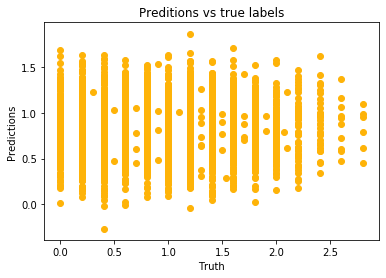

In [220]:
plt.scatter(truth_all*3, preds_all*3)
plt.title('Preditions vs true labels')
plt.xlabel('Truth')
plt.ylabel('Predictions')

In [ ]:
# Try predicting [MASK]

In [238]:
h, c = run_pretrained_for_sentence('This is a [MASK] sentences', len_sent = 5)

In [245]:
h[0][4]

tensor([-4.8467e-01, -1.5410e-01,  4.5676e-01, -2.6751e-01, -3.5279e-01,
         1.6615e-01, -4.5834e-03,  1.0484e-01, -3.8521e-01,  1.4572e-01,
        -3.9893e-01, -6.4346e-02, -5.1810e-01, -8.5108e-02,  4.5921e-01,
        -1.2399e-01,  9.1444e-02, -2.4186e-01,  1.1553e-01, -2.4419e-01,
         4.1332e-01,  5.0311e-01, -1.0818e-01, -4.9766e-01,  4.6253e-01,
         2.1118e-01,  1.7978e-01, -3.3571e-01, -2.3409e-01,  2.6158e-01,
        -2.4863e-01, -4.7928e-02,  1.0342e-01,  1.3792e-01, -3.0125e-01,
        -2.4333e-01, -3.8122e-01, -5.7470e-02, -8.6543e-02, -1.2808e-02,
         8.1096e-02, -2.9649e-01, -1.5015e-01, -1.8059e-01, -2.8193e-01,
         2.8478e-01, -4.3849e-01,  1.9499e-01, -2.1680e-01, -1.0943e-01,
        -4.6547e-01,  2.4702e-02,  6.0991e-01,  3.7529e-01, -2.8480e-01,
         3.5469e-01, -1.9837e-01, -3.7996e-01,  1.5978e-01, -3.3056e-01,
         5.6390e-02,  2.3558e-01,  4.0455e-01,  3.9021e-01,  9.8947e-03,
         2.4133e-01, -6.7638e-02,  6.3117e-02, -8.1

In [240]:
h1, c1 = run_pretrained_for_sentence('This is a test sentences', len_sent = 5)

In [249]:
torch.dist(h1[0][4], h[0][4])

tensor(10.9222, grad_fn=<DistBackward>)

In [253]:
torch.dist(h1[0][5], h[0][5])

tensor(6.2370, grad_fn=<DistBackward>)

['i', 'am', '[MASK]']

In [257]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize('[MASK] am [MASK]'))

[103, 2572, 103]